## Introduction

Agent Catalog aims at simplifying your agent development process at scale by providing a consolidated view of tools and prompts used by agents as well as providing traceability through a logger. The logging also helps in iteratively modifying your workflow, tool, and/or prompts to ensure the best outcome from your agentic system every time.

User guide for Agent Catalog can be found [here](https://docs.google.com/document/d/1Fv-L_Hx-ljPARH5P9EN5PMS9Nu6_VOmALKtLJoPOC20/edit?usp=sharing).

Documentation for Agent Catalog can be found [here](https://couchbaselabs.github.io/agent-catalog/).


## Setup


In [1]:
import dotenv

dotenv.load_dotenv(dotenv.find_dotenv(usecwd=True))

True

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if os.environ.get(var) is None:
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

## Create graph

### Setup provider and auditor


In [3]:
import agentc

from langchain_core.tools import tool
from pydantic import SecretStr

provider = agentc.Provider(
    decorator=lambda t: tool(t.func),
    secrets={
        "CB_CONN_STRING": SecretStr(os.getenv("CB_CONN_STRING")),
        "CB_USERNAME": SecretStr(os.getenv("CB_USERNAME")),
        "CB_PASSWORD": SecretStr(os.getenv("CB_PASSWORD")),
    },
)

In [4]:
# Initialising the auditor to track the agents' thought processes
auditor = agentc.Auditor(agent_name="Sample Research Agent")

### Create nodes

In [5]:
from agentc.langchain import audit
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o", openai_api_key=os.environ["OPENAI_API_KEY"], temperature=0)


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal

#### Research agent and node

In [7]:
research_agent = create_react_agent(
    model=audit(llm, session="doc", auditor=auditor),
    tools=provider.get("tool", name="web_search"),
    state_modifier=provider.get("prompt", name="sampleapp_system_instructions").prompt.render(
        suffix="You can only do research. You are working with a chart generator colleague."
    ),
)

In [8]:
def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

#### Charting agent and node

In [9]:
chart_agent = create_react_agent(
    model=audit(llm, session="doc", auditor=auditor),
    tools=provider.get("tool", name="repl_tool"),
    state_modifier=provider.get("prompt", name="sampleapp_system_instructions").prompt.render(
        suffix="You can only generate charts. You are working with a researcher colleague."
    ),
)

In [10]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Create graph

In [11]:
from langgraph.graph import START
from langgraph.graph import StateGraph

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

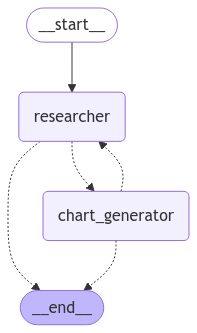

In [12]:
from IPython.display import Image
from IPython.display import display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke agents

First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----


Python REPL can execute arbitrary code. Use with caution.


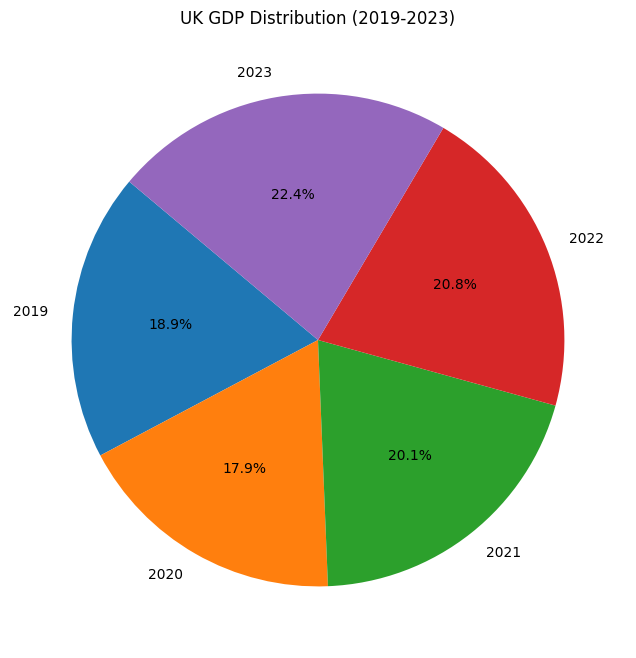

First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----
FINAL ANSWER

Here is a summary of the UK's GDP over the past 5 years along with a pie chart:

- **2019**: $2.85 trillion
- **2020**: $2.70 trillion
- **2021**: $3.03 trillion
- **2022**: $3.14 trillion
- **2023**: $3.38 trillion

The pie chart below represents the distribution of the UK's GDP from 2019 to 2023:

![UK GDP Distribution (2019-2023)](attachment://uk_gdp_pie_chart.png)
----


In [13]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)

for event in events:
    for key in event:
        for msg in event[key]["messages"]:
            if isinstance(msg, HumanMessage):
                print(msg.content)
                print("----")